# Analysis for fires in Sentinel-1 images
This notebook analyses fires in sentinel-1 VV/VH images. This should motivate the usage of S1 images in detecting fires.
#### Content
- loading S1 image
- displaying s1 on the 17th. 
- finding boxes and a line to analyse.
- analysing the line
- analysing the boxes (briefly)



#### Next step
- looking at the change in the fire area. Hopefully, this will show some texture of the fire that can be analysed using e.g. BLOB analysis or smth..





------------
Firstly, importing packages, functions and paths



In [2]:
import numpy as np
import sys
#Folder with my own functions(my_s1, my_s3 and my_modis)
sys.path.append('C:\\Users\\krist\\Documents\\Syntese\\code')
#Folder where im fetching the data from
sys.path.append('C:\\Users\\krist\\Documents\\Syntese\\data\\s1')
#my functions
import my_s1 as s1
import my_modis as md
import my_tools as tools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.ndimage
from collections import deque
from bisect import insort, bisect_left
from itertools import islice


def s1_plot_hist(images):
    """
    plotting histograms of list of images. Using a constant false alarm rate of 1 and 99 % respecttivly..
    
    kristian
    """
    
    for i in range(len(images)):
        img_cfar = images[i][(images[i]>np.quantile(images[i], 0.01)) &  (images[0]<np.quantile(images[i], 0.99))]
        #Plotting 
        hist_cfar,bins_cfar = np.histogram((img_cfar).ravel(),bins=51)
        width_cfar = 0.7 * (bins_cfar[1] - bins_cfar[0])
        center_cfar = (bins_cfar[:-1] + bins_cfar[1:]) / 2     
        plt.bar(center_cfar, hist_cfar, align='center', width=width_cfar)
        plt.title('Historgram')
        plt.xlabel("Intensity", fontsize=16)  
        plt.ylabel("Amout of pixels", fontsize=16)
        plt.xticks(fontsize=14)  
        plt.yticks(fontsize=14)

    plt.show()
    return None


from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(img, size):
    """
    a simple adaptive lee filter, see the authors report on speckle filtering (2017)
    """
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

def running_mean(x, N):
    """
    calculating runnin mean of a vector. Used for analysis a line..
    """
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / N


def running_median(img, size):
    """
    calculating runnin median of a vector. Used for analysis a line..
    """
    img = iter(img)
    d = deque()
    s = []
    result = []
    for item in islice(img, size):
        d.append(item)
        insort(s, item)
        result.append(s[len(d)//2])
    m = size // 2
    for item in img:
        old = d.popleft()
        d.append(item)
        del s[bisect_left(s, old)]
        insort(s, item)
        result.append(s[m])
    return result

### Loading image


-----------------------

As seen from the output of the function, see below (displayed since verbose=1), we have 1 image. This image has two bands, VV and VH respecticly.

![title](brand_d_23_shape.PNG)

Firstly loading an image. The image loaded is taken from the Sentinel-1 satellite on 17th of July 2018 above the area of Ljusdal where the largest wildfire of 2018 happend.




### Displaying images

In [3]:
#the folder where the s1 images are located.
folder_path = "C:\\Users\\krist\\Desktop\\til_inge"
#getting all files with extention .tif.
img_paths = s1.file_paths(folder_path,verbose=1,file_type='tif')


there are: 3  . tif  files in folder


Only loading 1 image. Loading all the bands in it.

In [4]:
images,raster,extend, names, extra = s1.get_img([img_paths[-1]],data_type='ENVI')

images loading

1 images are being loaded
imgage 1
There are 4 bands


Displaying the image, the boxes and the line as used for the analysis..

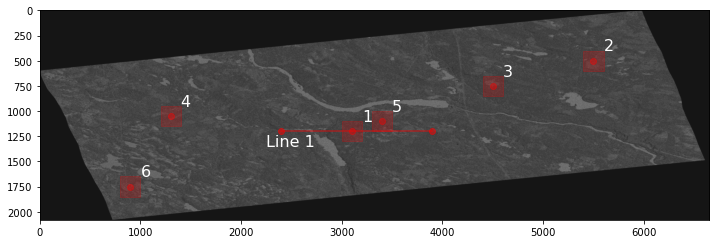

In [5]:
centroids_analysis_s1 = []
centroids_analysis_s1.append([3100,1200])
centroids_analysis_s1.append([5500,500])
centroids_analysis_s1.append([4500,750])
centroids_analysis_s1.append([1300,1050])
centroids_analysis_s1.append([3400,1100])
centroids_analysis_s1.append([900,1750])

#for saving, here is the name..
name = 'test_image_with_areas.png'
#depending on what I wanna see..
#img = (images[3]-1)*(-1)
#img =tools.img_stretch(images[3])
img= lee_filter(images[1],5)
#img  =images[1]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
axes.imshow(img,cmap='binary')
#plt.xlabel('Longitude [deg]', fontsize=18)
#plt.ylabel('latitude [deg]', fontsize=18)
#plt.xticks(fontsize=16)
#plt.yticks(fontsize=16)
#axes.set_xticks([])
#axes.set_yticks([])

# Extract the line...

x0, y0 = 3200, 300 
x1, y1 = 4200, 950
num = 2000
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
#zi = images[1][x.astype(np.int), y.astype(np.int)]
zi_vh = scipy.ndimage.map_coordinates(images[1], np.vstack((y,x)))
zi_vv = scipy.ndimage.map_coordinates(images[3], np.vstack((y,x)))

x0_2, y0_2 = 2400, 1200 
x1_2, y1_2 = 3900, 1200
num = x1_2-x0_2
x_2, y_2 = np.linspace(x0_2, x1_2, num), np.linspace(y0_2, y1_2, num)
#zi = images[1][x.astype(np.int), y.astype(np.int)]
zi_vh_2 = scipy.ndimage.map_coordinates(images[1], np.vstack((y_2,x_2)))
zi_vv_2 = scipy.ndimage.map_coordinates(images[3], np.vstack((y_2,x_2)))
axes.annotate('Line 1', (x0_2-150, y0_2+150),color='white', size=16)
#axes.annotate('Line 2', (x0_2-150, y0_2+150),color='white', size=16)


#showing boxes..
for i in range(len(centroids_analysis_s1)):
    rect = plt.Rectangle((centroids_analysis_s1[i][0]-100,centroids_analysis_s1[i][1]-100), 200, 200,color='red', alpha=0.2)
    axes.add_patch(rect)
    axes.scatter(centroids_analysis_s1[i][0],centroids_analysis_s1[i][1], alpha=0.4, color='r')
    axes.annotate(str(i+1), (centroids_analysis_s1[i][0]+100, centroids_analysis_s1[i][1]-100),color='white', size=16)


#plotting line 1..    
#plt.plot([x0, x1], [y0, y1], 'ro-', alpha=0.5)
plt.plot([x0_2, x1_2], [y0_2, y1_2], 'ro-', alpha=0.5)
#plt.title('17th of July image')

#plt.savefig(name, bbox_inches='tight', dpi=600)
plt.show()



#### Looking at Line 1!

Line 1 goes from a non-fire area, thorugh a fire area, ending up in a non fire area. Now, we aer analysing this line to see if there are any trends.

Especially the historgram made by the line, atop of box 1, is bearly visible in the S2 image. 
If this was able to be somewhat detected using s1, we are golden.

--------------------------------------

##### The line, and median

Below, we are plotting the values (the image has been dB converted). Moreover, a running median has been plotted (with an arbitraty kernal size showing the results I want). 
Firstly, the Line values are suuuper noisy, and it is really difficult to see any structure. 

In the running mean, we can somewhat see a little trend. This is analysies in the next plots.

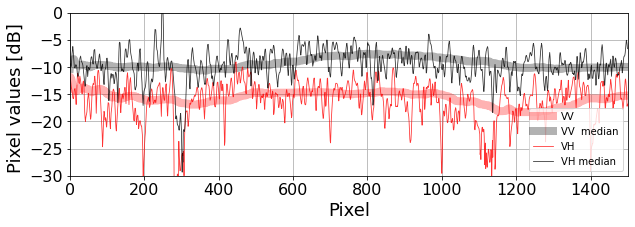

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
plt.plot(running_median(zi_vh_2,261), c='r', linewidth=8, alpha=0.3)
plt.plot(running_median(zi_vv_2,261), c='k', linewidth=8, alpha=0.3)
plt.plot((zi_vh_2), c='r', linewidth=0.8, alpha=0.8)
plt.plot((zi_vv_2), c='k', linewidth=0.8, alpha=0.8)
#plt.plot(running_mean(zi_vh_2,30), linewidth=6, alpha=0.1)
#plt.plot(running_mean(zi_vv_2,30), linewidth=6, alpha=0.1)
axs = plt.gca()
axs.set_ylim([-30,0])
#plt.title('Line 1')
name ='median_261_normal.png'
axs = plt.gca()
#axs.set_ylim([0,200])
axs.set_xlim([0,1500])
plt.xlabel('Pixel', fontsize=18)
plt.ylabel('Pixel values [dB] ', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend({'VH median','VV  median','VH','VV'},loc="lower right")
plt.grid()
#plt.title('Median values Line 1')
plt.savefig(name, bbox_inches='tight', dpi=600)


plt.show()

The values are now squarred to better illustrate trends/diferences ect. A running median is then made again. (the actual Line is just as noise when squared).

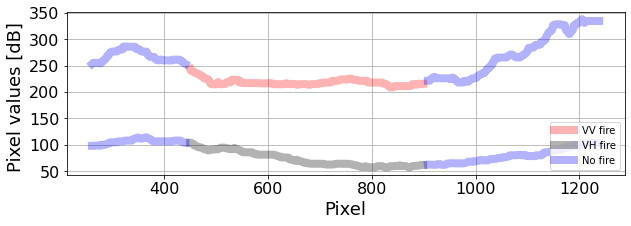

In [8]:
vec = range(0, num, 1)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
plt.plot(vec[450:900],running_median(zi_vh_2**2,261)[450:900], c='r', linewidth=8, alpha=0.3)
plt.plot(vec[450:900],running_median(zi_vv_2**2,261)[450:900], c='k', linewidth=8, alpha=0.3)

plt.plot(vec[908:-261],running_median(zi_vh_2**2,261)[908:-261], c='b', linewidth=8, alpha=0.3)
plt.plot(vec[261:442],running_median(zi_vh_2**2,261)[261:442], c='b', linewidth=8, alpha=0.3)


plt.plot(vec[908:-261],running_median(zi_vv_2**2,261)[908:-261], c='b', linewidth=8, alpha=0.3)
plt.plot(vec[261:442],running_median(zi_vv_2**2,261)[261:442], c='b', linewidth=8, alpha=0.3)

name ='median_261_squarred.png'
axs = plt.gca()
#axs.set_ylim([0,200])
plt.xlabel('Pixel', fontsize=18)
plt.ylabel('Pixel values [dB] ', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend({'VH fire','VV fire','No fire'},loc="lower right")
plt.grid()
#plt.title('Median values Line 1')
plt.savefig(name, bbox_inches='tight', dpi=600)
plt.show()


Alrighty. We can somewhat see a difference. This will be analysed further. 

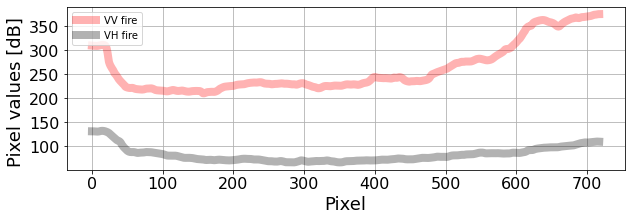

In [231]:
vec = range(0, num, 1)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
plt.plot(running_mean(zi_vh_2**2,261)[261:-261], c='r', linewidth=8, alpha=0.3)
plt.plot(running_mean(zi_vv_2**2,261)[261:-261], c='k', linewidth=8, alpha=0.3)


#plt.plot(vec[908:-261],running_mean(zi_vh_2**2,261)[908:-261], c='b', linewidth=8, alpha=0.3)
#plt.plot(vec[261:442],running_mean(zi_vh_2**2,261)[261:442], c='b', linewidth=8, alpha=0.3)


#plt.plot(vec[908:-261],running_mean(zi_vh_2**2,261)[908:-261], c='b', linewidth=8, alpha=0.3)
#plt.plot(vec[261:442],running_mean(zi_vv_2**2,261)[261:442], c='b', linewidth=8, alpha=0.3)

#name ='mean_261_squarred.png'
#axs = plt.gca()
#axs.set_ylim([0,200])
#plt.xlabel('Pixel', fontsize=18)
#plt.ylabel('Pixel values [dB] ', fontsize=18)
#plt.xticks(fontsize=16)
#plt.yticks(fontsize=16)
#plt.legend({'VH fire','VV fire','No fire'})
#plt.grid()
#plt.title('Median values Line 1')
#plt.savefig(name, bbox_inches='tight', dpi=600)
#plt.show()



This concluded a quick analysis of the line. Now, we will look a bit into the boxes.

# Boxes

6 Boxes are used. Box 1 and 5 contains fire. The rest are somewhat homogenous areas without a fire. The boxes are not neccesarily large enough to capture the structure of the fire, but the idea is they are big enough to capture the specific statistics. Later, the structure will be looked into, e.g. when comparing to ealier measurement.



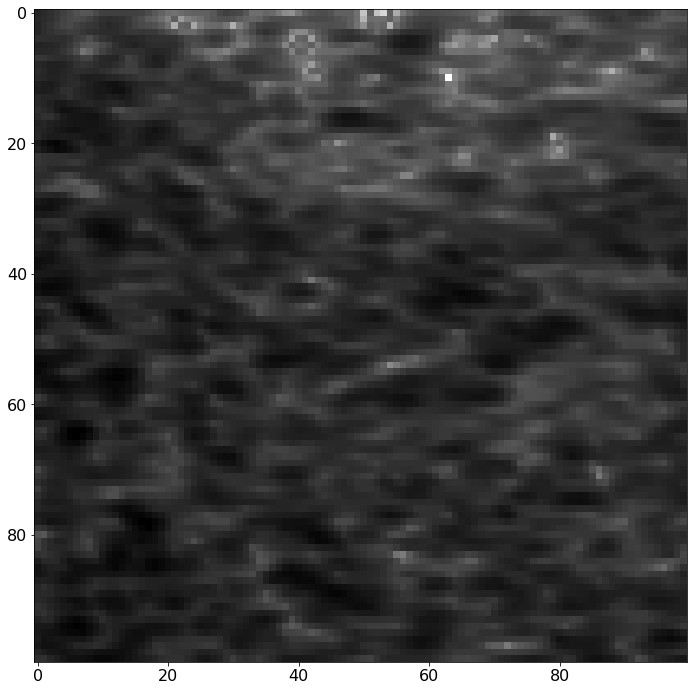

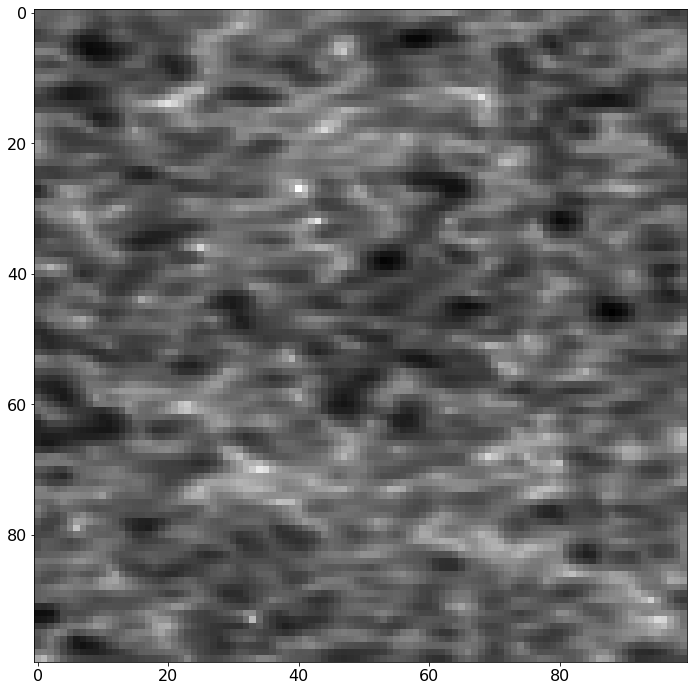

In [10]:
#Making the boxes into images...
fire_1_area_vh = images[1][1100:1200,3100:3200]
fire_2_area_vh = images[1][1000:1100,3400:3500]
fire_1_area_vv = images[3][1100:1200,3100:3200]
fire_2_area_vv = images[3][1000:1100,3400:3500]

no_fire_1_area_vh = images[1][400:500,5400:5500]
no_fire_2_area_vh= images[1][650:750,4400:4500]
no_fire_3_area_vh = images[1][950:1050,1200:1300]
no_fire_4_area_vh = images[1][1650:1750,800:900]
no_fire_1_area_vv = images[3][400:500,5400:5500]
no_fire_2_area_vv= images[3][650:750,4400:4500]
no_fire_3_area_vv = images[3][950:1050,1200:1300]
no_fire_4_area_vv = images[3][1650:1750,800:900]




#Just showing a fire
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
axes.imshow(fire_2_area_vh,cmap='binary')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#showing area without fire..
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
axes.imshow(fire_1_area_vh,cmap='binary')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# Saving boxes

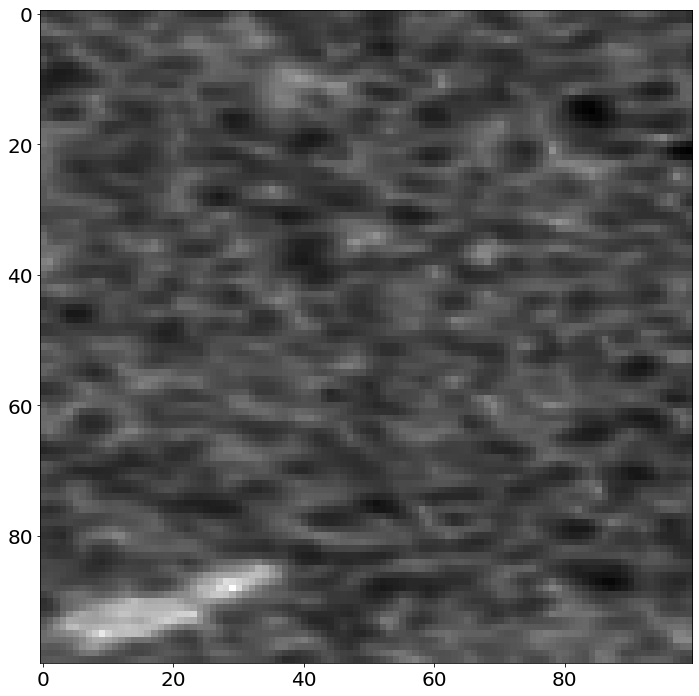

In [15]:
#name ='box_2_VV_normal.png'
#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
#axes.imshow(no_fire_1_area_vv,cmap='binary')
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
#plt.savefig(name, bbox_inches='tight', dpi=300)
#plt.show()

# Statistics of box

Trying to look at the intensities of the boxes. (just a first analysis..)




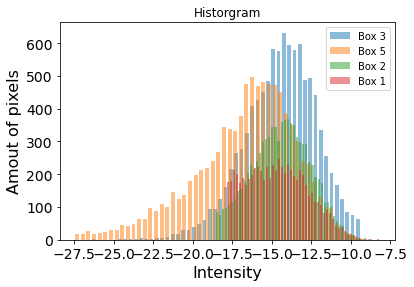

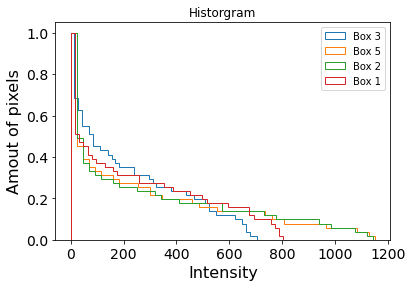

In [11]:
#the boxes I wanna see using 
imagesss = [fire_1_area_vh,fire_2_area_vh,no_fire_1_area_vh,no_fire_2_area_vh]

for i in range(len(imagesss)):
    img_cfar = imagesss[i][(imagesss[i]>np.quantile(images[i], 0.01)) &  (imagesss[0]<np.quantile(imagesss[i], 0.99))]
    #Plotting 
    hist_cfar,bins_cfar = np.histogram((img_cfar).ravel(),bins=51)
    width_cfar = 0.7 * (bins_cfar[1] - bins_cfar[0])
    center_cfar = (bins_cfar[:-1] + bins_cfar[1:]) / 2     
    plt.bar(center_cfar, hist_cfar, align='center', width=width_cfar, alpha=0.5)
    plt.title('Historgram')
    plt.xlabel("Intensity", fontsize=16)  
    plt.ylabel("Amout of pixels", fontsize=16)
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)
plt.legend({'Box 1','Box 5','Box 2','Box 3'})
plt.show()


for i in range(len(imagesss)):
    #img_cfar = imagesss[i][(imagesss[i]>np.quantile(images[i], 0.01)) &  (imagesss[0]<np.quantile(imagesss[i], 0.99))]
    img_cfar = imagesss[i]
    #Plotting 
    hist_cfar,bins_cfar = np.histogram((img_cfar).ravel(),bins=51)  
    plt.hist(hist_cfar,50,  density=True, histtype='step', alpha=1, cumulative=-1)
    plt.title('Historgram')
    plt.xlabel("Intensity", fontsize=16)  
    plt.ylabel("Amout of pixels", fontsize=16)
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)
plt.legend({'Box 1','Box 5','Box 2','Box 3'})
plt.show()



Getting means of no fire

In [12]:
no_fire_vh = np.array([no_fire_1_area_vh.ravel(), no_fire_2_area_vh.ravel(),no_fire_3_area_vh.ravel(),no_fire_4_area_vh.ravel()])
no_fire_vh_mean = np.mean(no_fire_vh, axis=0)
no_fire_vv = np.array([no_fire_1_area_vv.ravel(), no_fire_2_area_vv.ravel(),no_fire_3_area_vv.ravel(),no_fire_4_area_vv.ravel()])
no_fire_vv_mean = np.mean(no_fire_vv, axis=0)

In [13]:
no_fire_vv_mean

array([ -8.486982,  -8.075174,  -8.472146, ..., -10.818284, -10.388294,
       -10.301483], dtype=float32)

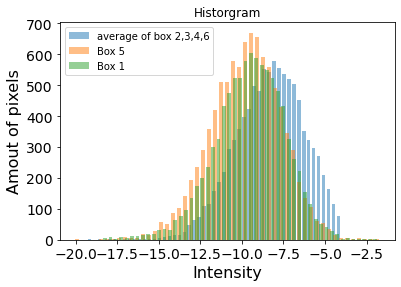

In [14]:
imagesss = [fire_1_area_vv,fire_2_area_vv,no_fire_1_area_vv]

for i in range(len(imagesss)):
    img_cfar = imagesss[i][(imagesss[i]>np.quantile(images[i], 0.01)) &  (imagesss[0]<np.quantile(imagesss[i], 0.99))]
    #Plotting 
    hist_cfar,bins_cfar = np.histogram((img_cfar).ravel(),bins=51)
    width_cfar = 0.7 * (bins_cfar[1] - bins_cfar[0])
    center_cfar = (bins_cfar[:-1] + bins_cfar[1:]) / 2     
    plt.bar(center_cfar, hist_cfar, align='center', width=width_cfar, alpha=0.5)
    plt.title('Historgram')
    plt.xlabel("Intensity", fontsize=16)  
    plt.ylabel("Amout of pixels", fontsize=16)
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)
plt.legend({'Box 1','Box 5','average of box 2,3,4,6'})
plt.show()

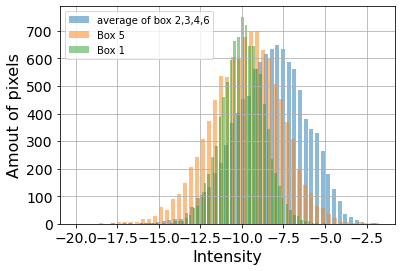

In [15]:
imagesss = [fire_1_area_vv,fire_2_area_vv,no_fire_vv_mean]

name ='pdf_fire_no_fire_mean_VV.png'


for i in range(len(imagesss)):
    #img_cfar = imagesss[i][(imagesss[i]>np.quantile(images[i], 0.01)) &  (imagesss[0]<np.quantile(imagesss[i], 0.99))]
    #Plotting 
    hist_cfar,bins_cfar = np.histogram((imagesss[i]).ravel(),bins=51)
    width_cfar = 0.7 * (bins_cfar[1] - bins_cfar[0])
    center_cfar = (bins_cfar[:-1] + bins_cfar[1:]) / 2     
    plt.bar(center_cfar, hist_cfar, align='center', width=width_cfar, alpha=0.5)
    plt.xlabel("Intensity", fontsize=16)  
    plt.ylabel("Amout of pixels", fontsize=16)
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)
plt.legend({'Box 1','Box 5','average of box 2,3,4,6'})
plt.grid()
plt.savefig(name, bbox_inches='tight', dpi=300)
plt.show()

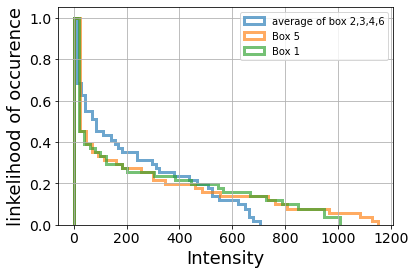

In [18]:
name ='cummolative_fire_no_fire_mean_VH.png'

imagesss = [fire_1_area_vh,fire_2_area_vh,no_fire_vh_mean]
for i in range(len(imagesss)):
    #Plotting 
    hist_cfar,bins_cfar = np.histogram((imagesss[i]).ravel(),bins=51)  
    plt.hist(hist_cfar,50,  density=True, histtype='step', alpha=.65, cumulative=-1, linewidth=3)
    plt.xlabel("Intensity", fontsize=18)  
    plt.ylabel("linkelihood of occurence", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)
plt.legend({'Box 1','Box 5','average of box 2,3,4,6'})
axs = plt.gca()
#axs.set_xlim([0.1,760])
plt.grid()
plt.savefig(name, bbox_inches='tight', dpi=600)
plt.show()




# variance

In [19]:
var_vv = [np.var(fire_1_area_vv),np.var(fire_2_area_vv),np.var(no_fire_1_area_vv),np.var(no_fire_2_area_vv),np.var(no_fire_3_area_vv),np.var(no_fire_4_area_vv)]
var_vh = [np.var(fire_1_area_vh),np.var(fire_2_area_vh),np.var(no_fire_1_area_vh),np.var(no_fire_2_area_vh),np.var(no_fire_3_area_vh),np.var(no_fire_4_area_vh)]

In [20]:
enl = []
for L in range(1,7,1):
    E = 1
    VAR = (var_vv[L-1]**2)/L
    ENL = (E**2)/VAR
    enl.append(ENL)
    

In [21]:
enl

[0.051716819716528584,
 0.0967109657626003,
 0.07705240953694277,
 0.08441428654355013,
 0.20974604628238758,
 0.23004110490078805]

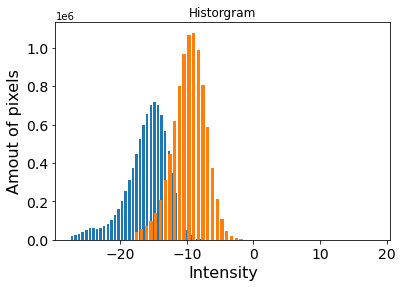

In [22]:
s1_plot_hist([images[1],images[3]])

### Histogram


A nice way of analysing images are by looking at the histogram. Below is shown the histogram for the entire image. 

First, for the histogram of the entire image in both VV and VH polarization is shown. Here, we see somewhat og a gamma distribution(as illustrated by the calculated PDF). Moreover, we see that there are large numbers of pixels with saturated values close to 0 and 1.  Lastly, we see that the pixel values for VV and VH are slightly different in intensity. This is due to the change in polarization/cross polarisation.

-----------------------------

In oder to better analyse the SAR iamge, these pixel values are filtered out from the histogram using a constant false alarm rate (CFAR). The constant false alarm rate will find a lower and upper threshold value, and use this to filter out pixel above and below these respecticly. The CFAR method is a adapting method, based on the upper 99 and lower 1 percent values of the histogram. 


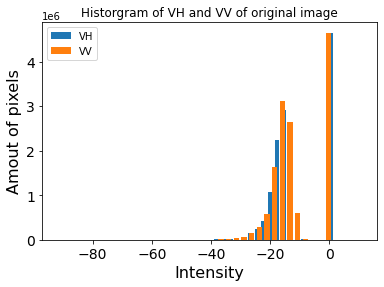

In [23]:
import cv2
from scipy import stats  
bands = ['VH','VV']

hist,bins = np.histogram((images[0]).ravel(),bins=40)
hist2,bins2 = np.histogram((images[1]).ravel(),bins=40)
width = 0.7 * (bins[1] - bins[0])
width2 = 0.7 * (bins2[1] - bins2[0])
center = (bins[:-1] + bins[1:]) / 2
center2 = (bins2[:-1] + bins2[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.bar(center2, hist2, align='center', width=width2)
plt.title('Historgram of VH and VV of original image')

plt.legend(bands)
plt.xlabel("Intensity", fontsize=16)  
plt.ylabel("Amout of pixels", fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.show()

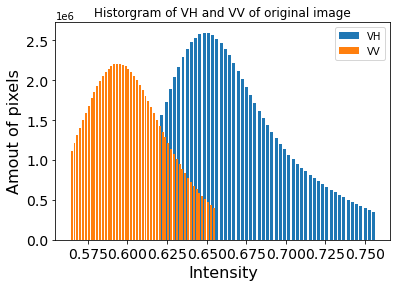

In [39]:
from scipy.stats import gamma
import scipy.stats as ss

#CFAR
imgVV_cfar =images[0][(images[0]>np.quantile(images[0], 0.01)) &  (images[0]<np.quantile(images[0], 0.99))]
imgVH_cfar =images[1][(images[1]>np.quantile(images[1], 0.01)) &  (images[1]<np.quantile(images[1], 0.99))]
#Plotting 
hist_cfar,bins_cfar = np.histogram((imgVV_cfar).ravel(),bins=51)
hist2_cfar,bins2_cfar = np.histogram((imgVH_cfar).ravel(),bins=51)
width_cfar = 0.7 * (bins_cfar[1] - bins_cfar[0])
width2_cfar = 0.7 * (bins2_cfar[1] - bins2_cfar[0])
center_cfar = (bins_cfar[:-1] + bins_cfar[1:]) / 2
center2_cfar = (bins2_cfar[:-1] + bins2_cfar[1:]) / 2
plt.bar(center_cfar, hist_cfar, align='center', width=width_cfar)
plt.bar(center2_cfar, hist2_cfar, align='center', width=width2_cfar)
plt.title('Historgram of VH and VV of original image')

plt.legend(bands)
plt.xlabel("Intensity", fontsize=16)  
plt.ylabel("Amout of pixels", fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.show()

del imgVV_cfar, imgVH_cfar, hist_cfar, hist2_cfar




Moreover, a histogram of a fire region, a non fire region, a homogeneus region and an inhomogenues region is shown. It is thus possible to see a small(very small) statistical difference between them.


### Histogram of city


In [40]:
city_VH = images[0][7500:8500,5500:6500]
city_VV = images[1][7500:8500,5500:6500]

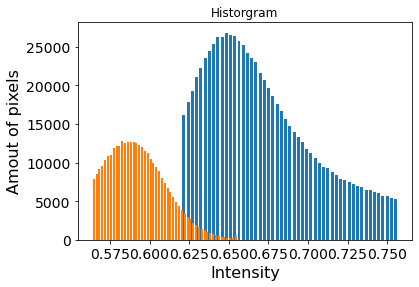

In [41]:
s1_plot_hist([images[0][7500:8500,5500:6500],images[1][7500:8500,5500:6500]])